## Notebook to implement importance sampling procedure for ages estimated under neutrality
##### Feb, 2023

In [5]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
# method of moments framework + helper functions
from mom_functions import *

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [102]:
# os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims/')
dft = pd.read_csv('outfiles/ConstantSize100.0.1.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
dft['empty'] = ''
dft['sXl'] = (dft['Xl']*200).astype('int')
dft['al'] = 80000+1 - dft['al']
dft['al'] = dft['al'].astype('int')
dft = dft.iloc[:,1:]
datt = dft.to_numpy()

SMS = np.zeros((80000,200+1),dtype='int16')
mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
for i in range(len(datt)):
    SMS[datt[i,2],datt[i,5]] += 1
SMSmask = np.ma.array(SMS,mask=mask)

# plt.spy(SMSmask,aspect='auto',color='salmon',marker='+',markersize=2,alpha=0.8); plt.xlabel('# of alleles (i)'); plt.ylabel('allele age (a)'); plt.ylim((0,12000))

sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200))

     fun: 688.5787
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 39
     nit: 27
 success: True
       x: -100.61962979696008

In [127]:
## inferring selection coefficients using estimated ages from Relate
## (can also build in an inference framework in which we randomly sample from a dist of posterior)
# relest = np.zeros((datt.shape[0],2))
# for ial, al in enumerate(datt[:,3]):
#     relout = pd.read_csv("msselfiles/relfiles/outfiles/out100.0_{}.mut".format(int(al)),delimiter=';')
#     relest[ial,0] = 1 if (relout['age_begin'][relout['pos_of_snp']==500000]==0).bool() else relout['age_begin'][relout['pos_of_snp']==500000]
#    relest[ial,1] = relout['age_end'][relout['pos_of_snp']==500000]

gevest = np.zeros((datt.shape[0],1))
for ial, al in enumerate(datt[:,3]):
    try:
        gevout = pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(int(al)),delimiter=' ')
    except:
        gevout = pd.DataFrame(np.full((1,5),np.nan))
    gevest[ial,0] = gevout.iloc[0,4]


(array([18.000, 22.000, 11.000, 6.000, 3.000, 0.000, 0.000, 0.000, 0.000,
        1.000]),
 array([40.194, 139.686, 239.178, 338.670, 438.163, 537.655, 637.147,
        736.639, 836.131, 935.623, 1035.115]),
 <BarContainer object of 10 artists>)

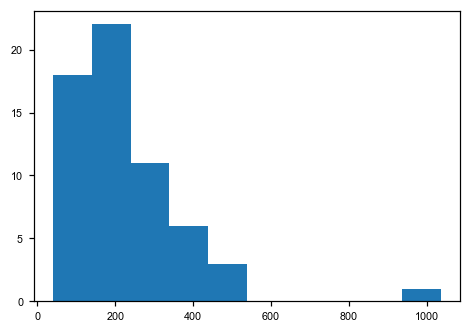

In [129]:
# np.int_(rng.uniform(relest[-2:,0],relest[-2:,1]))
# pd.read_csv('msselfiles/gevafiles/outfiles/out100.0_{}.sites2.txt'.format(16004057),delimiter=' ')

In [105]:
## running it on the midpoint
# datt = np.append(datt, np.int_(relest.mean(axis=1)).reshape(-1,1), 1)
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     SMS[datt[i,6],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)
# gamest = [sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x]

# running it on a uniform draw from the distribution
# for reps in range(20):
#     datt[:,6] = np.int_(rng.uniform(relest[:,0]+1,relest[:,1]))
#     SMS = np.zeros((80000,200+1),dtype='int16')
#     mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
#     for i in range(len(datt)):
#         SMS[datt[i,6],datt[i,5]] += 1
#     SMSmask = np.ma.array(SMS,mask=mask)

#     gamest.append(sp.optimize.minimize_scalar(get_ll_freqageconstant_notfm,args=({'sms':SMSmask,'theta':400,'N':10000,'p_misid':0,'gens':80000},200)).x)

In [136]:
# plt.boxplot([g for g in gamest]); plt.axhline(-100,color='red',ls='-',label='true'); plt.axhline(gamest[0],color='grey',ls='-.',label='est. using midpoint'); plt.axhline(-100.62,color='b',ls='--',label='est. using sim.'); plt.legend()
# SMS = np.zeros((80000,200+1),dtype='int16')
# mask = np.zeros_like(SMS); mask[0,:] = 1; mask[:,0] = 1; mask[:,-1] = 1;
# for i in range(len(datt)):
#     if datt[i,7]==0:
#         continue
#     SMS[datt[i,7],datt[i,5]] += 1
# SMSmask = np.ma.array(SMS,mask=mask)

[-180.2139653744981]

### Importance sampling scheme method

Below is code to deal with the underestimation of $\gamma$ for higher values, as ages are estimated under the neutral prior. 